In [587]:
import numpy as np
from numpy import random
import pandas as pd
import pygraphviz as pgv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import itertools

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


def rule_one_possible(string):
    
    # If the last letter of the current string is I, rule 1 can be applied
    
    if string[-1:] == 'I':
        return True
    
    else:
        return False


def rule_two_possible(string):
    
    # If the first letter of the current string is M, rule 2 can be applied
    
    if string[:1] == 'M':
        return True
    else:
        return False


def rule_three_possible(string):
    
    # If the current string contains III, rule 3 can be applied
     
    if string.find('III') != -1:
        return True
    else:
        return False
    

def rule_four_possible(string):
    
    # If the current string contains UU, rule 4 can be applied
    
    if string.find('UU') != -1:
        return True
    else:
        return False    
    

def rule_three_indices(string):
    
    indices = [index for index, char in enumerate(string) if string.startswith('III', index)]

    return indices


def get_options(string):

    options = dict()

    if rule_one_possible(string):
        #options['1'] = apply_rule_one(string)
        options[apply_rule_one(string)] = '1'

    if rule_two_possible(string):
        #options['2'] = apply_rule_two(string)
        options[apply_rule_two(string)] = '2'

    if rule_three_possible(string):
        for index in rule_three_indices(string):
            #options[f'3i{index}'] = apply_rule_three(string, index)
            options[apply_rule_three(string, index)] = f'3i{index}'
        
    if rule_four_possible(string):
        #options['4'] = apply_rule_four(string)
        options[apply_rule_four(string)] = '4'

    return options

    
def apply_rule_one(string):
    
    return string + 'U'


def apply_rule_two(string):
    
    return string + string[1:]


def apply_rule_three(string, index):
    
    return string[:index] + 'U' + string[index+3:]


def apply_rule_four(string):
    
    # the output of rule four is invariant under which index it is applied at
    
    index = string.find('II')
    
    string = string[:index] + string[index+2:]

    return string


def random_traversal(string, num_steps):
    
    # take a random walk through the local network 
    
    path = dict()
    rules = [None,]
    strings = [string,]
    
    i=0
    while i < num_steps:

        options = get_options(string)
        print(options)
        
        string = random.choice(list(options.keys()))
        rule = options[string]
        
        strings.append(string)
        rules.append(rule)
    
        i+=1
        
    path['rules'] = rules
    path['strings'] = strings

    return path


def discover_local_network(string, num_steps):

    nodes = set([string])
    edges = dict()
    
    i=0
    while i<num_steps:
        
        new_neighbours = []
        for node in nodes:
            
            neighbour_rule_pairs = get_options(node)
            
            for neighbour_rule_pair in neighbour_rule_pairs.items():

                edges[tuple([node, neighbour_rule_pair[0]])] = neighbour_rule_pair[1]

                new_neighbours.append(neighbour_rule_pair[0])

        for new_neighbour in new_neighbours:
            nodes.add(new_neighbour)

        i+=1
    
    network = dict()
    network['nodes'] = nodes
    network['edges'] = edges
    
    return network


In [403]:
network = discover_local_network('MI', num_steps=5)

adj = pd.DataFrame(0, index = network['nodes'], columns=network['nodes'])

for edge in network['edges']:
    adj.loc[edge[1], edge[0]] = 1

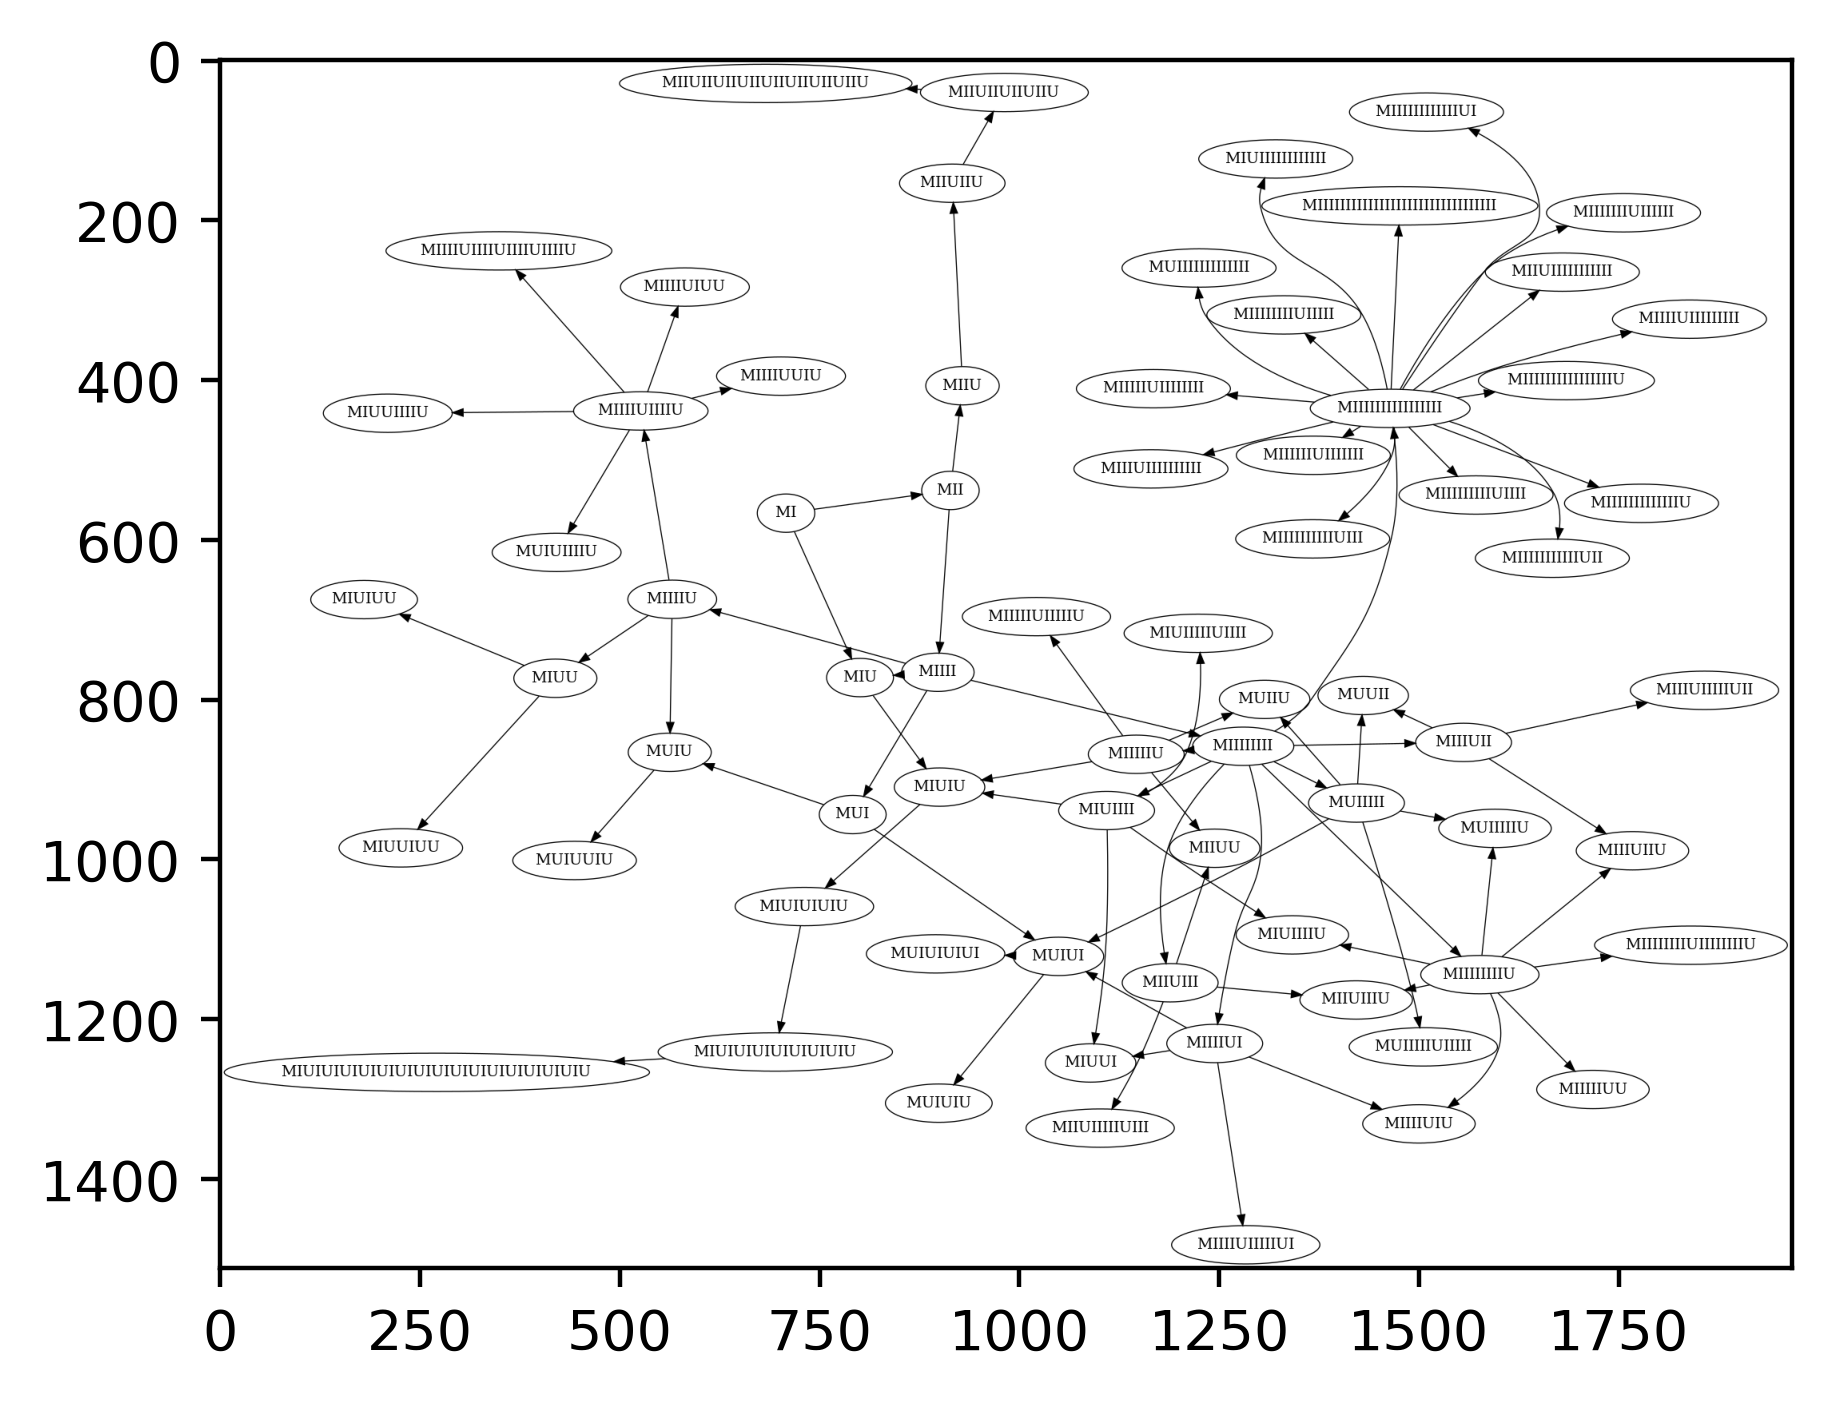

In [404]:
# plot the network

plt.rcParams['figure.dpi'] = 400

dag = pgv.AGraph(directed=True, overlap='false', splines='true')

for node in network['nodes']:
    dag.add_node(node)

for edge in network['edges']:
    dag.add_edge(edge)

dag.layout(prog='fdp')  #neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten.
dag.draw('dag.png')

img = mpimg.imread('dag.png')
plt.imshow(img)
plt.show()